## Name: Nikita Bhrugumaharshi Emberi

# STA 220 Assignment 3

Due __Februrary 23, 2024__ by __11:59pm__. Submit your work by uploading it to Gradescope through Canvas.

Instructions:

1. Provide your solutions in new cells following each exercise description. Create as many new cells as necessary. Use code cells for your Python scripts and Markdown cells for explanatory text or answers to non-coding questions. Answer all textual questions in complete sentences.
2. The use of assistive tools is permitted, but must be indicated. You will be graded on you proficiency in coding. Produce high quality code by adhering to proper programming principles. 
3. Export the .jpynb as .pdf and submit it on Gradescope in time. To facilitate grading, indicate the area of the solution on the submission. Submissions without indication will be marked down. No late submissions accepted. 
4. If test cases are given, your solution must be in the same format. 
5. The total number of points is 10. 

__(a, i)__ Write a function that retrieves all links to movies in the database by scraping the _alphabetical_ section on [imsdb.com](https://imsdb.com/) and retrieve the links. _How many links did you find?_ __(ii)__ Write a function `fetch_script` that, given the link of a movie retrieved in (i), returns a dictionary that contains all relevant information of the movie: 

```python
fetch_script('/Movie Scripts/10 Things I Hate About You Script.html')

>>> {'title': '10 Things I Hate About You',
     'writers': ['Karen McCullah Lutz', 'Kirsten Smith', 'William Shakespeare'],
     'genres': ['Comedy', 'Romance'],
     'date': 1997,
     'script': '...'}
```

The `script` field contains a string of the scraped script. Retrieve the information for all movies. _How many scripts did you retrieve?_

#### Importing Required Libraries

In [2]:
import requests
import lxml.html as lx
import time
import pandas as pd
import matplotlib.pyplot as plt
import requests_cache
import re
import concurrent.futures, threading
import numpy as np
from tqdm import tqdm
from urllib.parse import quote
import pickle

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import TimeoutException

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
import seaborn as sns

=============================================================================================================================================
__(a, i)__ Write a function that retrieves all links to movies in the database by scraping the _alphabetical_ section on [imsdb.com](https://imsdb.com/) and retrieve the links. _How many links did you find?_


In [5]:
url = "https://imsdb.com/"

In [6]:
# Sending a GET request to the specified URL
result = requests.get(url)

# Raising an exception if the request isn't successful
result.raise_for_status()

In [7]:
# Initializing a Chrome webdriver instance
driver = webdriver.Chrome()

# Setting a page load timeout of 20 seconds
driver.set_page_load_timeout(20) # twenty seconds should be enough

try:
    # Attempt to load the URL in the browser
    driver.get(url)
except TimeoutException:
    # If the page load times out, stop loading the page
    driver.execute_script("window.stop();")

In [8]:
#function that retrieves all links to movies in the database by scraping the alphabetical section
def all_movie_links(href):
    time.sleep(0.2)
    # Navigating to the URL using your web driver
    driver.get("https://imsdb.com/" + href)

    # Extracting the HTML content of the webpage for the specific alphabet
    alphabet_html = lx.fromstring(driver.page_source)

    # Extracting movie links from the HTML content using XPath
    links = alphabet_html.xpath('//*[@id="mainbody"]/table[2]/tbody/tr/td[3]/p/a/@href')

    # Extending the list of movie links with the extracted links
    return links

In [9]:
# Initializing an empty list to store movie links
movie_links = []

# Extracting the HTML content of the webpage currently loaded in the web driver
html = lx.fromstring(driver.page_source)

# Finding the table containing alphabet links on the webpage
alphabets_table = html.xpath('//*[@id="mainbody"]/table[2]/tbody/tr/td[1]/table[2]/tbody/tr/td')

# Iterating over each row in the table starting from the second row
for i in tqdm(range(1, len(alphabets_table))):
    time.sleep(0.2)

    # Extracting the hyperlink element corresponding to the alphabet link
    alphabet_link = alphabets_table[i].xpath('.//a')[0] 
    href = alphabet_link.get("href")  # Get the href attribute value

    links = all_movie_links(href)

    # Extending the list of movie links with the extracted links
    movie_links.extend(links)

100%|███████████████████████████████████████████| 27/27 [00:24<00:00,  1.10it/s]


## Final Answer:

In [10]:
print(f"Number of retrieved links to movies in the database by scraping the alphabetical section is: {len(movie_links)}")

Number of retrieved links to movies in the database by scraping the alphabetical section is: 1221


In [11]:
driver.quit()

=============================================================================================================================================
__(a ii)__ Write a function `fetch_script` that, given the link of a movie retrieved in (i), returns a dictionary that contains all relevant information of the movie: 

In [17]:
thread_local = threading.local()

def get_session():
    '''Create a new requests.Session if there is none in thread_local'''
    if not hasattr(thread_local, "session"): 
        thread_local.session = requests.Session()
    return thread_local.session

In [18]:
# Defining a list to store URLs of movies without scripts
movies_without_scripts = []

def fetch_script(movie_link):
    session = get_session()
    try:
        movie_dict = {}
        base_url = "https://imsdb.com"
        encoded_movie_link = quote(movie_link, safe='/:')  # Encode the movie link
        # Constructing the full URL for the movie
        url = base_url + encoded_movie_link
    

        # Sending a GET request to the URL
        response = session.get(url)
        response.raise_for_status()  # Raise an exception for unsuccessful requests
        
        html = lx.fromstring(response.text)
        
        ############ Movie Title #########################################
        
        title = html.xpath("//table[@class='script-details']/tr[1]/td/h1")

        # Check if the body_div is not empty before printing
        if title:
            movie_dict['title'] = title[0].text
        else:
            print("Unable to find the title.")

        
        ############ Movie Writers #########################################    
        writers_elements = html.xpath('''//table[@class='script-details']/tr[2]/td[2]
                                /b[contains(text(), 'Writers')]
                                /following::a[following::b[contains(text(), 'Genres')]]''')

        if writers_elements:
            writers = [element.text for element in writers_elements if element is not None]
            movie_dict['writers'] = writers

        ############ Movie Genres #########################################    
        genres = html.xpath('''//table[@class='script-details']/tr[2]/td[2]
                        /b[contains(text(), 'Genres')]
                        /following::a[starts-with(@href, '/genre/')]''')
        if genres:
            genres_list = [element.text for element in genres if element is not None]
            movie_dict['genres'] = genres_list
            
        ############ Movie Script Date #########################################  
        script_date = html.xpath('''//table[@class='script-details']/tr[2]/td[2]
                                //b[contains(text(), 'Script Date')]/following-sibling::text()[1]''')

        if script_date:
            movie_dict['date'] = script_date[0].split()[-1].strip("']")
        

         ############ Movie Script ######################################### 
        script = html.xpath('''//table[@class='script-details']/tr[2]/td[2]
                                /a[starts-with(@href, '/scripts/')]/@href''')

        if script:
            script_url = "https://imsdb.com/" + script[0]
            script_response = requests.get(script_url)
            try:
                script_response.raise_for_status()
                script_html = lx.fromstring(script_response.text)
                script_text = script_html.xpath('//td[@class="scrtext"]/pre')
                movie_dict['script'] = script_text[0].text_content()  
            except Exception as e:
                movies_without_scripts.append(script_url)
                movie_dict['script'] = ""   
        else:
            movie_dict['script'] = ""

        # Returning the movie dictionary
        return movie_dict
            
    except requests.exceptions.RequestException as e:
        print(url)
        print("Error during request:", e)
    except Exception as e:
        print(url)
        print("An error occurred:", e)
    


In [19]:
def perform_concurrent_threading(pages):
    # Defining the total number of tasks
    total_tasks = len(pages)
    
    # Creating a progress bar using tqdm
    with tqdm(total=total_tasks, desc="Processing pages") as progress_bar:
        # Using ThreadPoolExecutor with tqdm to create a progress bar
        with concurrent.futures.ThreadPoolExecutor(max_workers = 12) as executor:
            # Using executor.map() to apply the function to each page
            answers = list(tqdm(executor.map(fetch_script, pages), total=total_tasks, desc="Processing pages", position=0))
            progress_bar.update(total_tasks)

    return answers

In [20]:
movie_data = perform_concurrent_threading(movie_links)

Processing pages: 100%|█████████████████████| 1221/1221 [01:08<00:00, 17.84it/s]


## Final Answer:

In [36]:
print("========= Example of Information Retrieved for a Movie =========")
print()
last_movie = movie_data[0]
print(f"Title: {last_movie['title']}")
print(f"Writers: {', '.join(last_movie['writers'])}")
print(f"Genres: {', '.join(last_movie['genres'])}")
print(f"Date: {last_movie['date']}")
print(f"Script (excerpt): \n{last_movie['script'][500: 1000]}")  # Print random text from the script because if I print the entire text
                                                                # the output would look cumbersome

========= Example of Information Retrieved for a Movie =========

Title: 10 Things I Hate About You Script
Writers: Karen McCullah Lutz, Kirsten Smith, William Shakespeare
Genres: Comedy, Romance
Date: 1997
Script (excerpt): 
          Welcome to Padua High School,, your typical urban-suburban 
          high school in Portland, Oregon.  Smarties, Skids, Preppies, 
          Granolas. Loners, Lovers, the In and the Out Crowd rub sleep 
          out of their eyes and head for the main building.
          
          PADUA HIGH PARKING LOT - DAY
          
          KAT STRATFORD, eighteen, pretty -- but trying hard not to be 
          -- in a baggy granny dress and glasses, balances a cup of 
          coffe


=============================================================================================================================================
The `script` field contains a string of the scraped script. Retrieve the information for all movies. _How many scripts did you retrieve?_

In [114]:
movies_with_scripts = sum(1 for data in movie_data if data['script'] != "")

## Final Answer:

In [115]:
print(f"The number of movies that contain scripts: {movies_with_scripts}")

The number of movies that contain scripts: 1150


In [122]:
print(f"========= Example Movie Links which do not have script =========")
movies_without_scripts[:5]

========= Example Movie Links which do not have script =========


['https://imsdb.com//scripts/8-Mile.pdf',
 'https://imsdb.com//scripts/Back-to-the-Future-II-%2526-III.pdf',
 'https://imsdb.com//scripts/Back-to-the-Future.pdf',
 'https://imsdb.com//scripts/Blues-Brothers,-The.pdf',
 'https://imsdb.com//scripts/Clockwork-Orange,-A.pdf']

=============================================================================================================================================
__(b)__ We are interested in the genres `'Musical'`, `'Horror'`, and `'Romance'`. Craft a barplot displaying the absolute counts for each of these categories. In each bar, color-code the fractions of movies that are also counted in another genres. 

In [323]:
movie_genres = []
genre_counts = [[0,0,0], [0,0,0], [0,0,0]]

# Iterating through each movie in the movie_data list
for movie in tqdm(movie_data):
    # Extracting the genres list for the current movie
    genres_list = movie['genres']
    movie_genres.append(genres_list)


    if "Musical" in genres_list:
        # Count Total Number of Movies in Musical Genre
        genre_counts[0][0] = genre_counts[0][0] + 1
        if "Horror" in genres_list:
            # Count Total Number of Movies in Musical & Horror Genres
            genre_counts[0][1] = genre_counts[0][1] + 1
            genre_counts[1][0] = genre_counts[1][0] + 1
        if "Romance" in genres_list:
            # Count Total Number of Movies in Musical & Romance Genres
            genre_counts[0][2] = genre_counts[0][2] + 1
            genre_counts[2][0] = genre_counts[2][0] + 1

    if "Horror" in genres_list:
        # Count Total Number of Movies in Horror Genre
        genre_counts[1][1] = genre_counts[1][1] + 1
        # Count Total Number of Movies in Horror & Romance Genres
        if "Romance" in genres_list:
            genre_counts[1][2] = genre_counts[1][2] + 1
            genre_counts[2][1] = genre_counts[2][1] + 1

    if "Romance" in genres_list:
        # Count Total Number of Movies in Horror Genre
        genre_counts[2][2] = genre_counts[2][2] + 1
    

100%|███████████████████████████████████| 1221/1221 [00:00<00:00, 381556.04it/s]


In [14]:
genre_names = ['Musical', 'Horror', 'Romance']
for i in range(len(genre_counts)):
    genre_counts[i].insert(0, genre_names[i])

In [15]:
print(f"Dataframe to store count values: ")
df = pd.DataFrame(genre_counts, columns=['Genre_Names', 'Musical', 'Horror', 'Romance'])
df

Dataframe to store count values: 


,Genre_Names,Musical,Horror,Romance
0,Musical,27,4,5
1,Horror,4,158,7
2,Romance,5,7,211


In [19]:
print("Count of Movies:")
print(f"Total Number of Movies in Musical Genre: {df.iloc[0,1]}")
print(f"Total Number of Movies in Musical-Horror Genre: {df.iloc[0, 2]}")
print(f"Total Number of Movies in Musical-Romance Genre: {df.iloc[0, 3]}")
print(f"Total Number of Movies in Horror Genre: {df.iloc[1, 2]}")
print(f"Total Number of Movies in Horror-Romance Genre: {df.iloc[1, 2]}")
print(f"Total Number of Movies in Romance Genre: {df.iloc[2, 3]}")

Count of Movies:
Total Number of Movies in Musical Genre: 27
Total Number of Movies in Musical-Horror Genre: 4
Total Number of Movies in Musical-Romance Genre: 5
Total Number of Movies in Horror Genre: 158
Total Number of Movies in Horror-Romance Genre: 158
Total Number of Movies in Romance Genre: 211


## Final Answer:

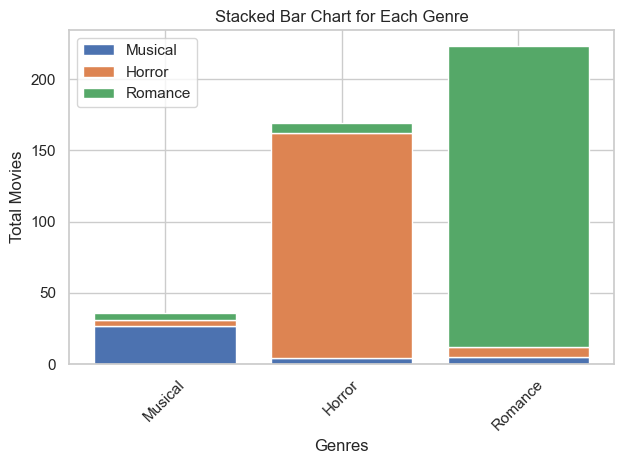

In [334]:
import matplotlib.pyplot as plt
import pandas as pd

# Plotting
fig, ax = plt.subplots()

# Stacked bar plot for each genre
genres = df['Genre_Names']
bottom = None
for genre in genres:
    if genre != 'Genre_Names':
        ax.bar(genres, df[genre], label=genre, bottom=bottom)
        bottom = df[genre] if bottom is None else bottom + df[genre]

# Adding labels and title
ax.set_xlabel('Genres')
ax.set_ylabel('Total Movies')
ax.set_title('Stacked Bar Chart for Each Genre')
ax.legend()


# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


=============================================================================================================================================
__(c, i)__ Using only regex, write a function `tokenizer` that returns bigrams of all non-whitespace and non-punctuation characters, according to the test case below: 

```python
test = '''
    Neque porro quisquam est, qui dolorem ipsum quia dolor sit amet, 
    consectetur, adipisci velit, sed quia non numquam eius modi tempora 
    incidunt ut labore et dolore magnam aliquam quaerat voluptatem.
'''
tokenizer(test)
>>> ['neque porro',
 'porro quisquam',
 'quisquam est',
 'qui dolorem',
 'dolorem ipsum',
 'ipsum quia',
 'quia dolor',
 'dolor sit',
 'sit amet',
 'adipisci velit',
 'sed quia',
 'quia non',
 'non numquam',
 'numquam eius',
 'eius modi',
 'modi tempora',
 'incidunt ut',
 'ut labore',
 'labore et',
 'et dolore',
 'dolore magnam',
 'magnam aliquam',
 'aliquam quaerat',
 'quaerat voluptatem']
 ```

In [150]:
sample_answer = ['neque porro',
 'porro quisquam',
 'quisquam est',
 'qui dolorem',
 'dolorem ipsum',
 'ipsum quia',
 'quia dolor',
 'dolor sit',
 'sit amet',
 'adipisci velit',
 'sed quia',
 'quia non',
 'non numquam',
 'numquam eius',
 'eius modi',
 'modi tempora',
 'incidunt ut',
 'ut labore',
 'labore et',
 'et dolore',
 'dolore magnam',
 'magnam aliquam',
 'aliquam quaerat',
 'quaerat voluptatem']

In [15]:
def tokenizer(text):
    # Initializing an empty list to store bigrams
    bigrams_main = []
    # Removing extra whitespace and punctuation from the text using regular expressions
    text = re.sub(r'[()\[\]]', '', text) 

    # Splitting the text into sentences using various punctuation marks and newlines as delimiters
    splitted_text = re.split(r'[.,!?;\n-]', text) 
    for text in splitted_text:
        # Removing non-alphanumeric characters and multiple whitespaces from the sentence
        cleaned_text = re.sub(r'[^\w\s]', '', text)
        cleaned_text = re.sub(r'\s+', ' ', text)
        # Converting the cleaned sentence to lowercase
        cleaned_text = cleaned_text.lower()
        # Splitting the cleaned sentence into individual words
        words = cleaned_text.split()

         # A bigram is created by concatenating two consecutive words in the list
        bigrams = [words[i] + ' ' + words[i+1] for i in range(len(words) - 1)]

        # Extending the bigrams_main list with the generated bigrams
        bigrams_main.extend(bigrams)
    
    return bigrams_main

In [313]:
test = '''
    Neque porro quisquam est, qui dolorem ipsum quia dolor sit amet, 
    consectetur, adipisci velit, sed quia non numquam eius modi tempora 
    incidunt ut labore et dolore magnam aliquam quaerat voluptatem.
'''

## Final Answer:

In [314]:
my_answer = tokenizer(test)
my_answer

['neque porro',
 'porro quisquam',
 'quisquam est',
 'qui dolorem',
 'dolorem ipsum',
 'ipsum quia',
 'quia dolor',
 'dolor sit',
 'sit amet',
 'adipisci velit',
 'sed quia',
 'quia non',
 'non numquam',
 'numquam eius',
 'eius modi',
 'modi tempora',
 'incidunt ut',
 'ut labore',
 'labore et',
 'et dolore',
 'dolore magnam',
 'magnam aliquam',
 'aliquam quaerat',
 'quaerat voluptatem']

In [315]:
print(f"Proof that tokenizer function returns bigrams as intended: ")
sample_answer == my_answer

Proof that tokenizer function returns bigrams as intended: 


True

__(ii)__ Use the tokenizer to obtain a tf-idf vector for each movie. Perform a (non-centered) principal component analysis (`sklearn.decomposition.TruncatedSVD`). _What fraction of variation is explained by the first principal component?_ __(iii)__ Generate a strip-plot for the first principal components versus all three genres. Does visualization indicate that a good classification could result from this approach? 

=============================================================================================================================================
__(c ii)__ Use the tokenizer to obtain a tf-idf vector for each movie. Perform a (non-centered) principal component analysis (`sklearn.decomposition.TruncatedSVD`). _What fraction of variation is explained by the first principal component?_

In [4]:
# Filtering movie_data to include only 'Horror', 'Musical', and 'Romance' genres
movie_data_filtered = [movie for movie in movie_data if any(genre in movie['genres'] for genre in ['Horror', 'Musical', 'Romance'])]

In [243]:
# Extracting movie descriptions and genres from filtered movie data
descriptions = [movie['script'] for movie in movie_data_filtered]
genres = [genre for movie in movie_data_filtered for genre in movie['genres'] if genre in ['Horror', 'Musical', 'Romance']]

In [244]:
# Initializing a TfidfVectorizer object with a custom tokenizer function
# Tokenizer function tokenizer() is used to tokenize the text data
tfidf_vec = TfidfVectorizer(tokenizer = tokenizer) 

# Transforming the text data into a TF-IDF matrix
# Fit-transforming the descriptions data using the initialized TfidfVectorizer
# This step converts the descriptions into a TF-IDF representation
tfidf = tfidf_vec.fit_transform(descriptions)

In [245]:
tfidf.shape

(380, 1201131)

In [246]:
# Initializing TruncatedSVD with the desired number of components (in this case, 1 component)
pca = TruncatedSVD(n_components=1)

# Fitting TruncatedSVD to the transposed TF-IDF matrix
pca.fit(tfidf.T)

TruncatedSVD(n_components=1)

## Final Answer:

In [247]:
# Obtaining the fraction of variance explained by the first principal component
fraction_of_variance_explained = pca.explained_variance_

# The explained_variance_ attribute of TruncatedSVD contains the variance explained by each of the selected components
# Since we only have one component in this case (n_components=1), we access the first element of the array to get the 
# fraction of variance explained by the first principal component
print(f"Fraction of variation explained by the first principal component: {fraction_of_variance_explained[0]}")

Fraction of variation explained by the first principal component: 2.8693667009199373e-05


#### ================ If I remove Null scripts =========================

In [37]:
# Filtering movie_data to include only 'Horror', 'Musical', and 'Romance' genres
movie_data_filtered = [movie for movie in movie_data if movie['script'] != "" if any(genre in movie['genres'] for genre in ['Horror', 'Musical', 'Romance'])]

In [38]:
# Extracting movie descriptions and genres from filtered movie data
descriptions = [movie['script'] for movie in movie_data_filtered]
genres = [genre for movie in movie_data_filtered for genre in movie['genres'] if genre in ['Horror', 'Musical', 'Romance']]

In [39]:
# Initializing a TfidfVectorizer object with a custom tokenizer function
# Tokenizer function tokenizer() is used to tokenize the text data
tfidf_vec = TfidfVectorizer(tokenizer = tokenizer) 

# Transforming the text data into a TF-IDF matrix
# Fit-transforming the descriptions data using the initialized TfidfVectorizer
# This step converts the descriptions into a TF-IDF representation
tfidf = tfidf_vec.fit_transform(descriptions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [40]:
tfidf.shape

(365, 1104555)

In [41]:
# Initializing TruncatedSVD with the desired number of components (in this case, 1 component)
pca = TruncatedSVD(n_components=1)

# Fitting TruncatedSVD to the transposed TF-IDF matrix
pca.fit(tfidf.T)

TruncatedSVD(n_components=1)

## Final Answer:

In [42]:
# Obtaining the fraction of variance explained by the first principal component
fraction_of_variance_explained = pca.explained_variance_

# The explained_variance_ attribute of TruncatedSVD contains the variance explained by each of the selected components
# Since we only have one component in this case (n_components=1), we access the first element of the array to get the 
# fraction of variance explained by the first principal component
print(f"Fraction of variation explained by the first principal component: {fraction_of_variance_explained[0]}")

Fraction of variation explained by the first principal component: 3.1132681022237206e-05


=============================================================================================================================================
__(c iii)__ Generate a strip-plot for the first principal components versus all three genres. Does visualization indicate that a good classification could result from this approach? 

In [335]:
# Obtain the principal components from the TruncatedSVD model
principal_components = pca.components_

print(f"Principal Components Shape: {principal_components.T.shape}")
principal_components

Principal Components Shape: (380, 1)


array([[5.08006784e-02, 4.09065566e-02, 5.91091139e-02, 4.48181787e-02,
        9.68426900e-25, 6.24605709e-02, 2.72987625e-02, 5.63759472e-02,
        2.10343613e-02, 4.74172415e-02, 3.17737599e-02, 4.28734094e-02,
        6.04319846e-02, 5.49639297e-02, 3.58403750e-02, 5.37350105e-02,
        6.04645257e-02, 6.19720458e-02, 4.97665266e-02, 5.67941981e-02,
        5.36335550e-02, 5.02179351e-02, 4.88267961e-02, 4.64732659e-02,
        5.15369124e-02, 6.97110853e-02, 6.20130988e-02, 6.42862819e-02,
        3.85113892e-02, 4.72763374e-02, 5.73495614e-02, 6.03373525e-02,
        4.92424845e-02, 6.10082414e-02, 2.99498246e-02, 5.29709609e-02,
        3.94160391e-02, 3.76814646e-02, 1.65347344e-02, 0.00000000e+00,
        6.17793363e-02, 4.71985838e-02, 4.59416038e-02, 5.53540954e-02,
        6.13207447e-02, 5.98110708e-02, 5.37294277e-02, 5.36198006e-02,
        5.55008004e-02, 2.41963407e-02, 5.72103245e-02, 4.97578024e-02,
        8.05191093e-02, 6.92932919e-02, 6.31555989e-02, 5.197738

In [26]:
selected_genres = ["Musical", "Horror", "Romance"]
selected_scripts = []
selected_genres_extended = []
for movie in movie_data:
    for genre in movie['genres']:
        if genre in selected_genres:
            selected_scripts.append(movie['script'])
            selected_genres_extended.append(genre)
            break

## Final Answer:

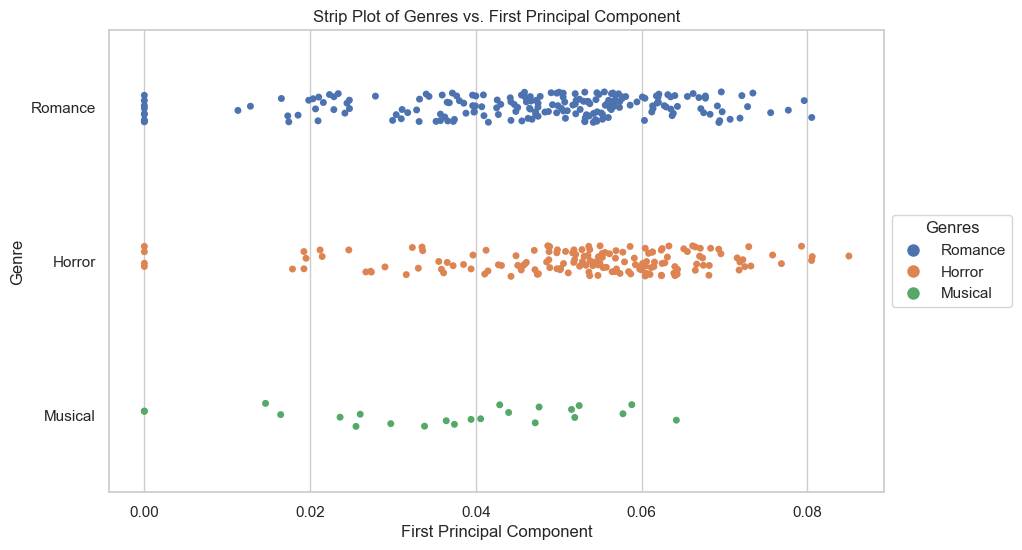

In [276]:
# Creating a DataFrame from the transposed principal components matrix, naming the column as 'PC1'
pc_df = pd.DataFrame(principal_components.T, columns=['PC1'])

# Adding a column named 'Genre' to the DataFrame, containing the genre information from selected_genres_extended
pc_df['Genre'] = selected_genres_extended


plt.figure(figsize=(10, 6))
strip = sns.stripplot(x='PC1', y='Genre', data=pc_df, jitter=True, hue='Genre')
plt.title('Strip Plot of Genres vs. First Principal Component')
plt.xlabel('First Principal Component')
plt.ylabel('Genre')


unique_genres = pc_df['Genre'].unique()

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sns.color_palette()[i], 
                             markersize=10, label=genre) for i, genre in enumerate(unique_genres)]

# Adding legend
plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), title='Genres')
plt.show()

#### ===================================================================================

### Does visualization indicate that a good classification could result from this approach?

The data points are spread out without clear distinctions between genres, making it hard to create an accurate classifier. Instances of data overlapping between genres indicate it's tough to draw clear boundaries. Even though the first principal component shows the main direction of variability in the data, it might not help much in distinguishing between genres. This shows how tricky it is to classify data when dealing with multiple genres. If the first principal component accounts for a large part of the variability (like more than 70%), it suggests there are some underlying patterns that could help with classification. However, the small amount of variation (2.8693667009199373e-05) in our data is a limitation. Despite this, we can see some clusters of genres in the plot, which suggests classification might be possible, but it's still challenging because genres can overlap.

#### ===================================================================================

#### ================ If I remove Null scripts =========================

In [25]:
principal_components = pca.components_

In [26]:
selected_genres = ["Musical", "Horror", "Romance"]
selected_scripts = []
selected_genres_extended = []
for movie in movie_data:
    if movie['script'] != "":
        for genre in movie['genres']:
            if genre in selected_genres:
                selected_scripts.append(movie['script'])
                selected_genres_extended.append(genre)
                break

## Final Answer:

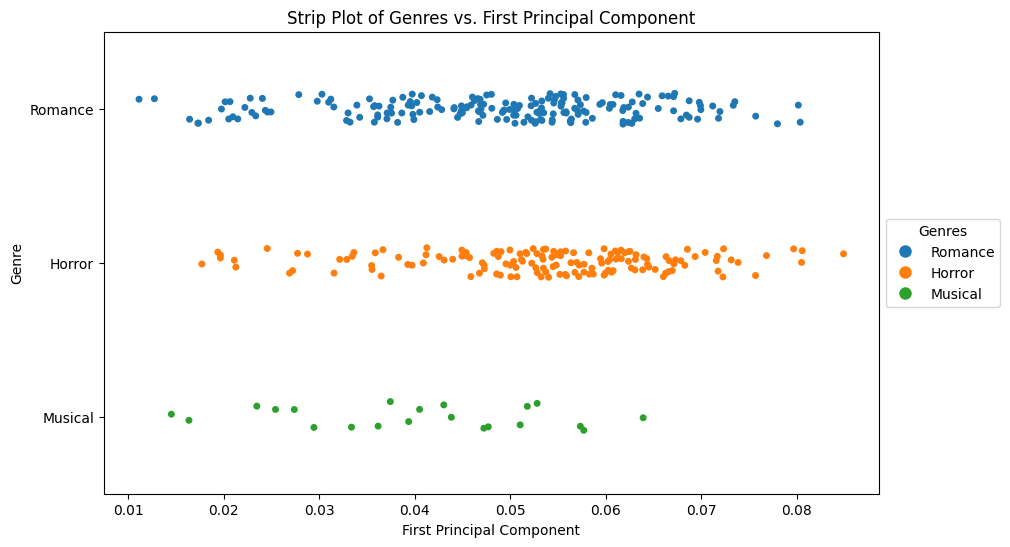

In [27]:
# Creating a DataFrame from the transposed principal components matrix, naming the column as 'PC1'
pc_df = pd.DataFrame(principal_components.T, columns=['PC1'])

# Adding a column named 'Genre' to the DataFrame, containing the genre information from selected_genres_extended
pc_df['Genre'] = selected_genres_extended


plt.figure(figsize=(10, 6))
strip = sns.stripplot(x='PC1', y='Genre', data=pc_df, jitter=True, hue='Genre')
plt.title('Strip Plot of Genres vs. First Principal Component')
plt.xlabel('First Principal Component')
plt.ylabel('Genre')


unique_genres = pc_df['Genre'].unique()

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sns.color_palette()[i], 
                             markersize=10, label=genre) for i, genre in enumerate(unique_genres)]

# Adding legend
plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), title='Genres')
plt.show()

# Acknowledgment
I received assistance from `ChatGPT` while working on certain questions in this notebook. I want to clarify that I independently completed the majority of the tasks, seeking help only in instances where I encountered challenges or felt lost. The collaboration with ChatGPT was instrumental in providing guidance and insights during those moments.
ChatGpt: https://chat.openai.com/

--- Nikita Bhrugumaharshi Emberi

## References:
1) https://imsdb.com/